# API

In [14]:
import yaml

In [15]:
def generate_prompt(template,docstring,paper):
    with open(template, 'r') as f:
        prompt = f.read()
    
    with open(docstring, 'r') as f:
        docstring = f.read()
    
    with open('ground_truth.yaml', 'r') as f:
        gt = yaml.load(f, Loader=yaml.FullLoader)
    for val in gt:
        if val['arxiv'] == float(paper):
            hamiltonian = val['gt']
            symmetry = val['symmetry']
            break
    
    prompt = prompt.replace("{{docstring}}", '\n'+docstring).replace("{{hamiltonian}}", '\n'+hamiltonian).replace("{{symmetry}}", symmetry)

    output_fn= 'Outputs_o1/' + 'prompt_{int}_{decimal}'.format(int=paper.split('.')[0],decimal=paper.split('.')[1]) + '.md' 
    with open(output_fn, 'w') as f:
        f.write(prompt)
    return prompt

# Code-generation prompts

In [16]:
print(generate_prompt(template='prompt.md',docstring='docstring_triangular.md',paper='2004.04168'))

You are a condensed matter physicist working on the numerical calculation for the Hamiltonian of a system using the Hartree Fock method. I will provide you with the physical Hamitonian written in second quantized form as an equation in LaTeX. You should convert it into a class for the HartreeFockHamiltonian using Python and necessary packages, such as numpy and scipy.
This is a multiple-step problem, and you will execute this process by analyzing the equation and answering smaller questions sequentially in order to finally generate the class. The class has the following structure:

CLASS DOCSTRING: 
`
class HartreeFockHamiltonian:
  def __init__(self, N_shell, parameters:dict[str, Any], filling_factor: float=0.5):
    self.lattice = 'square' | 'triangular'
    self.D = # LM Task: has to define this tuple.
    self.basis_order = {'0': 'flavor_type_0', '1': 'flavor_type_1', ... 'D-1': 'flavor_type_D-1'}
    # this is the basis order that the Hamiltonian will follow

    # Occupancy relev

# LLM-Generated code

In [ ]:
task 1 (k-mesh) and 2 (noninteracting dispersion) is a always correct in claude
task 4 (large interaction limit) is also challenging due to Fock term

# Code evaluation

In [48]:
import sys
sys.path.append('Outputs_o1')
import matplotlib.pyplot as plt

import HF
import numpy as np
import inspect

In [49]:
def combine_code(library, code):
    return inspect.getsource(library) + inspect.getsource(code)

In [50]:
def plot_kspace(kspace):
    fig, ax = plt.subplots(figsize=(3,3),tight_layout=True)
    ax.scatter(*kspace.T,s=2)
    ax.set_aspect('equal')
    ax.set_xlabel('$k_x$')
    ax.set_ylabel('$k_y$')
def plot_matele(mat):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.spy((mat))
    ax.set_title('$H_0$')
def plot_2d_bandstructure(ham,en):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i in range(en.shape[0]):
        ax.plot_trisurf(ham.k_space[:,0],ham.k_space[:,1],en[i])
def plot_high_symm_bandstructure(k_list,en,ax=None): # DROP
    if ax is None:
        fig, ax = plt.subplots()
    for e in en:
        k_abs=np.sqrt(np.diff(k_list[:,0])**2 + np.diff(k_list[:,1])**2)
        k_abs = np.concatenate([[0],np.cumsum(k_abs)])
        ax.plot(k_abs,e,color='k')
    Nk = (k_list.shape[0]-1)//4
    for i in range(5):
        ax.axvline(k_abs[Nk*i],ls='--',color='r')
    ax.set_xticks([k_abs[Nk*i] for i in range(5)],['$\Gamma$','K','M','$\Gamma$',"K'"])
    # ax.set_xlim([k_abs[0],k_abs[-1]])

    

In [51]:
# from code_2004_04168_new_6 import *
# from code_2004_04168_claude_0 import *
# from code_2004_04168_claude_1 import *
from code_2004_04168_claude_2 import *


## Check k-space

In [52]:
ham = HartreeFockHamiltonian(N_shell=10,)

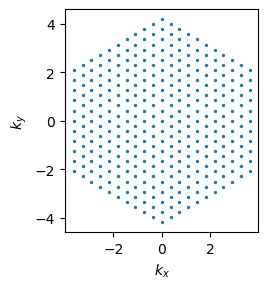

In [53]:
plot_kspace(kspace=ham.k_space)

## Check energy dispersion for non-interacting term

In [54]:
h_nonint = ham.generate_non_interacting()

In [55]:
wf,en= diagonalize(h_nonint) # or HF.diagonalize

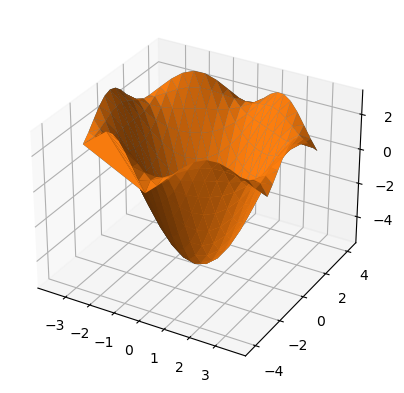

In [56]:
plot_2d_bandstructure(ham,en)

## Infinitesemial U limit

In [57]:
ham_int= HartreeFockHamiltonian(N_shell=10)

In [58]:
wf,en= diagonalize(ham_int.generate_non_interacting())
exp_val= get_exp_val(wf,en,0.5,0)

In [59]:
wf_int, en_int, exp_val= solve(ham_int,1e-10*exp_val,100)

Convergence reached at iteration 1


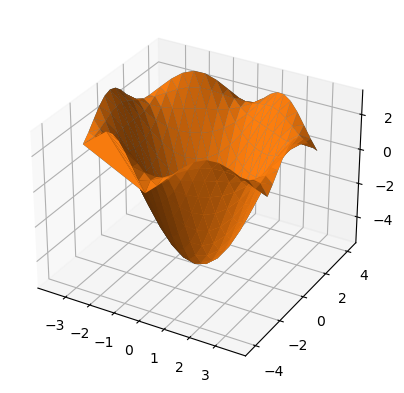

In [60]:
plot_2d_bandstructure(ham_int,en_int)

## Large U limit

In [63]:
ham_int= HartreeFockHamiltonian(N_shell=10, parameters={
                'a': 1.0,           # Lattice constant
                't_0': -1.0,        # Nearest neighbor hopping parameter
                't_1': 0.1,         # Next nearest neighbor hopping parameter
                'U_0': 2000.0,         # On-site Coulomb interaction
                'U_1': 0.5          # Nearest neighbor Coulomb interaction
            })

In [64]:
h_nonint=ham_int.generate_non_interacting()
h_nonint[0,0,:]-=100
wf,en=HF.diagonalize(h_nonint)
exp_val=HF.get_exp_val(wf,en,0.5,0)

In [65]:
wf_int, en_int, exp_val_int=HF.solve(ham_int,exp_val,100)

Convergence reached at iteration 4


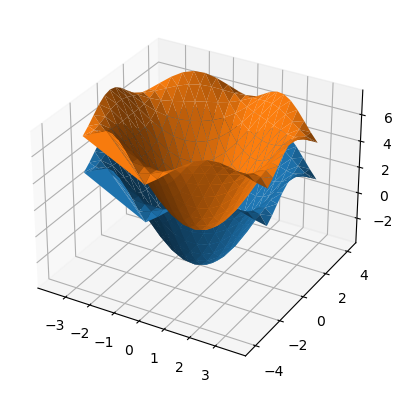

In [66]:
plot_2d_bandstructure(ham_int,en_int)

In [67]:
mean_U=np.abs(ham_int.generate_interacting(exp_val)).mean() 
mean_T=np.abs(ham_int.generate_non_interacting()).mean() 
gap = en_int[1].min()-en_int[0].max()

In [68]:
print(f'Gap is {gap:.2f}')
print(f'U/T is {mean_U/mean_T:.2f}')
print(f'mean_U is {mean_U:.2f}')

Gap is -5.86
U/T is 1.49
mean_U is 1.52
